# Neural Network structure

How should we think about the "layers" and the "nodes?"
When we say "1 hidden layer," what does that mean?

Let's build a network model and count the weights and biases we have there.

In [ ]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(2, 3),
    nn.Sigmoid(),
    nn.Linear(3, 1),
    nn.Sigmoid()
)

In [ ]:
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=3, out_features=1, bias=True)
  (3): Sigmoid()
)


In [ ]:
for name, param in model.named_parameters():
    if name == '2.weight':
        weight_tensor = param.data
    if name == '2.bias':
        bias_tensor = param.data

print(weight_tensor)
print(bias_tensor)

tensor([[ 0.3993,  0.5565, -0.4490]])
tensor([-0.4875])


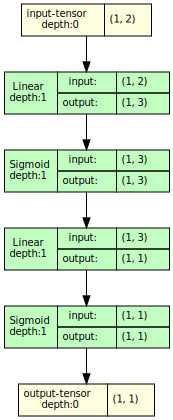

In [ ]:
!pip install torchview
from torchview import draw_graph
import torchvision.models as models

# Draw the graph
model_graph = draw_graph(model, input_size=(1, 2), expand_nested=False)
model_graph.visual_graph

# SUSY classification with Neural Networks and Decision Trees

If decision trees are great with structured data, then we expect them to do very well with the SUSY ML dataset.

Let's compare the performance for the simple DecisionTreeClassifier, XGBoost, and a deep neural network.

First we should develop some standards for the training set and the testing set.
What is a reasonable split of the data between training and testing?

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class CSVDataset(Dataset):
    def __init__(self, csv_file, max_samples=None):
        self.data = pd.read_csv(csv_file)
        if max_samples:
            self.data = self.data.iloc[:max_samples]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        features = torch.tensor(row.iloc[1:].values, dtype=torch.float32)
        label = torch.tensor(row.iloc[0], dtype=torch.float32)
        return features, label

In [ ]:
# Use it with DataLoader
dataset = CSVDataset('https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz', 10000)

# Define split ratios (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(
    dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}\n")


Training samples: 8000
Testing samples: 2000



In [ ]:
# DataLoaders handle batching, shuffling, and parallel loading
training_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testing_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

We will make sure the training is done on the training dataset.

In [ ]:
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Linear(18, 30),
    nn.Sigmoid(),
    nn.Linear(30, 1),
    nn.Sigmoid()
)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
# Training loop
for epoch in range(num_epochs):
    for batch_features, batch_labels in training_dataloader:
        # Forward pass
        predictions = model(batch_features)
        # Reshape batch_labels to match predictions
        loss = criterion(predictions, batch_labels.unsqueeze(1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 0.7101
Epoch [2/50], Loss: 0.6911
Epoch [3/50], Loss: 0.6564
Epoch [4/50], Loss: 0.6494
Epoch [5/50], Loss: 0.6253
Epoch [6/50], Loss: 0.5981
Epoch [7/50], Loss: 0.5962
Epoch [8/50], Loss: 0.5828
Epoch [9/50], Loss: 0.6613
Epoch [10/50], Loss: 0.5844
Epoch [11/50], Loss: 0.5679
Epoch [12/50], Loss: 0.6437
Epoch [13/50], Loss: 0.6242
Epoch [14/50], Loss: 0.6405
Epoch [15/50], Loss: 0.6477
Epoch [16/50], Loss: 0.6044
Epoch [17/50], Loss: 0.5999
Epoch [18/50], Loss: 0.6136
Epoch [19/50], Loss: 0.6071
Epoch [20/50], Loss: 0.6062
Epoch [21/50], Loss: 0.6391
Epoch [22/50], Loss: 0.6084
Epoch [23/50], Loss: 0.6060
Epoch [24/50], Loss: 0.6261
Epoch [25/50], Loss: 0.6861
Epoch [26/50], Loss: 0.6493
Epoch [27/50], Loss: 0.5621
Epoch [28/50], Loss: 0.6288
Epoch [29/50], Loss: 0.6274
Epoch [30/50], Loss: 0.6114
Epoch [31/50], Loss: 0.6453
Epoch [32/50], Loss: 0.6597
Epoch [33/50], Loss: 0.6732
Epoch [34/50], Loss: 0.5802
Epoch [35/50], Loss: 0.5590
Epoch [36/50], Loss: 0.6141
E

But the testing should be done on the testing dataset.
Check to see that the number of events (number of input vectors) is what you expect.

We'll also compare the loss value on the testing data to the last loss value on the training data.

tensor(0.6132)


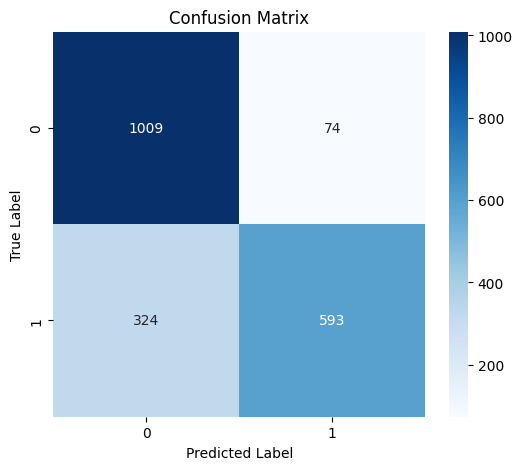

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get all predictions
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch_features, batch_labels in testing_dataloader:
        outputs = model(batch_features)
        predictions = (outputs > 0.5).float()
        loss = criterion(predictions, batch_labels.unsqueeze(1))
        all_predictions.extend(predictions.numpy())
        all_labels.extend(batch_labels.numpy())

print(loss)

# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Now let's try the decision tree, as implemented in scikit-learn.
We don't need the PyTorch dataloader here, just the training and testing datasets.
Unfortunately the training and testing datasets were made as Torch tensors (as seen in next cell), and we need simple numpy structures instead.

In [ ]:
print(train_dataset[0])
print(test_dataset[0])

(tensor([ 2.0075, -1.0858,  1.3968,  2.9848, -1.8287, -0.3735,  0.4110, -0.1999,
         0.1838, -0.0874,  2.1946,  1.0253,  0.4146,  0.2874,  2.2064,  0.3336,
         1.4154,  0.0726]), tensor(0.))
(tensor([ 0.6608,  0.3250,  1.3631,  0.8614,  0.4926, -1.4155,  0.3160, -1.0070,
         0.3154,  0.3565,  0.6167,  0.4588,  0.6601,  0.6324,  0.4316,  0.6856,
         0.4004,  0.2882]), tensor(0.))
[1.6679730415344238, 0.06419061869382858, -1.225171446800232, 0.5061022043228149, -0.33893898129463196, 1.6725428104400635, 3.475464344024658, -1.219136357307434, 0.012954562902450562, 3.7751736640930176, 1.0459771156311035, 0.568051278591156, 0.48192843794822693, 0.0, 0.4484102725982666, 0.20535576343536377, 1.3218934535980225, 0.3775840103626251]


The following code block does the data conversion for numpy and scikit-learn.

In [ ]:
import numpy as np
import torch

# Prepare training data
train_features_list = []
train_labels_list = []
for features, label in train_dataset:
    train_features_list.append(features)
    train_labels_list.append(label)

X_train = torch.stack(train_features_list).numpy()
y_train = torch.stack(train_labels_list).numpy()

# Prepare testing data
test_features_list = []
test_labels_list = []
for features, label in test_dataset:
    test_features_list.append(features)
    test_labels_list.append(label)

X_test = torch.stack(test_features_list).numpy()
y_test = torch.stack(test_labels_list).numpy()

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (8000, 18)
Shape of y_train: (8000,)
Shape of X_test: (2000, 18)
Shape of y_test: (2000,)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn import datasets # import inbuild datasets

from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix

score=[]
dtclassifier = DecisionTreeClassifier()
dtclassifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
print(dtclassifier.get_depth())
dtclassifier.score(X_train,y_train),dtclassifier.score(X_test,y_test)

30


(1.0, 0.6915)

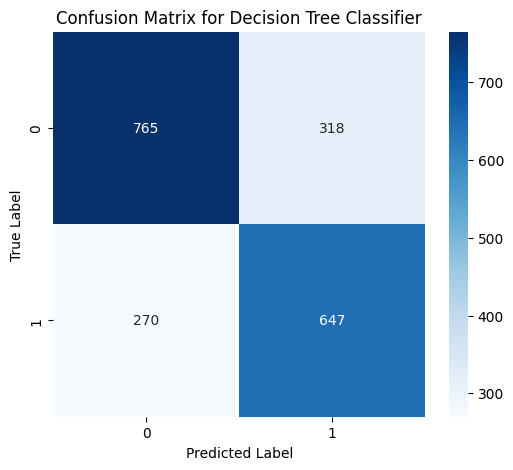

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions from the DecisionTreeClassifier on the test set
y_pred_dt = dtclassifier.predict(X_test)

# Create confusion matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Finally, let's try the XGBoost and see if the decision tree can be improved.

Fortunately XGBoost is also part of scikit-learn, so we can use the same training and testing dataset formats as for the DecisionTreeClassifier.

In [ ]:
from xgboost import XGBClassifier
import xgboost
xgbclf = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
# fit model
xgbclf.fit(X_train, y_train)
# make predictions
preds = xgbclf.predict(X_test)

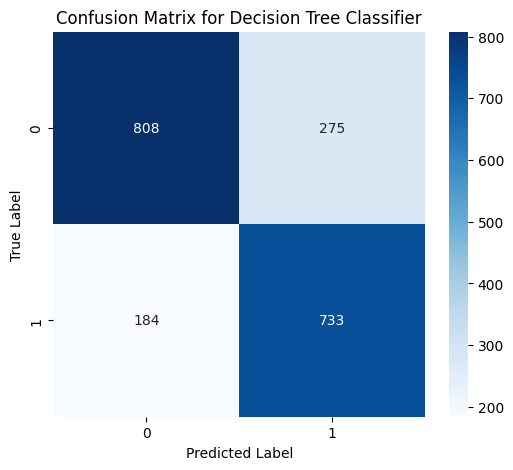

In [ ]:
# Get predictions from the DecisionTreeClassifier on the test set
y_pred_dt = xgbclf.predict(X_test)

# Create confusion matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Conclusions

Are the confusion matrices detailed enough to help us understand the performance of the various machine learning methods?

They help us calculate a "false positive rate" and a "true positive rate" for each ML algorithm.
We can explore different working points for each algorithm by changing the tree queries.

Here is an example of the "Receiver Operating Curve" that plots the tradeoff between "false positive rate" and a "true positive rate" on the same plot.

Can you guess which point on the curve represents the best overall performance? [Hint: the dotted blue line is a random classifier (a coin flip).]

[       inf 0.9520109  0.944916   0.8702464  0.8441149  0.80190384
 0.7550097  0.6467319  0.5778055  0.49952337 0.45687678 0.2523022
 0.13423769]


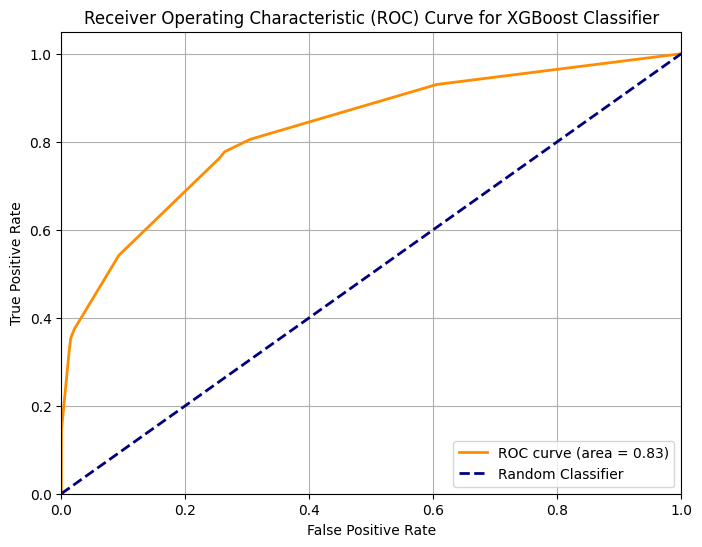

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_pred_proba_xgb = xgbclf.predict_proba(X_train)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba_xgb)
roc_auc = auc(fpr, tpr)
print(thresholds)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The point closest to the optimal point of (1.0, 1.0) is the best-performing network.
The other points on the plot represent different probabilities that are computed from the decision tree. They represent different leaf node combinations that can give a combined probability.